In this notebook I'll compare two different representation of the titanic dataset, one done by Scatter and Jitter plot and another - by ICC plot.

Link to dataset: [here](https://www.kaggle.com/datasets/prkukunoor/TitanicDataset)


<hr>

# Part 1: Loading the data

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/שנה א' - סמסטר א'/מדעי נתונים טבלאיים/מחברות לפרוייקט - ICC/titanic_data.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**Attributes Explaination:**

* PassengerId - unique passenger id.

* Survived - this is the class: 1, if the passenger survived and 0 otherwise.

* Pclass - the class of the ticket (1, 2 or 3).

* Name - passenger name.

* Sex - the gender of the passenger.

* Age - the age of the passenger.

* SibSp - number of siblings (Sib) and spouse (Sp) that were with the passenger onboard.

* Parch - number of parents (Par) and children (ch) that were with the passenger onboard.

* Ticket - ticket number.

* Fare - the price of the ticket.

* Cabin -  the number of the passenger's cabin in the ship.

* Embarked - the port in which the passenger boarded the ship.



# Part 2: Data processing

Remove irrelevant attributes for classification: PassengerId, Name, Ticket and Cabin - each has a unique value for each passenger.

In [ ]:
df.drop(['PassengerId','Name','Ticket','Cabin'],axis=1, inplace=True)

Fill missing values for "Age" with the mean value:

In [ ]:
df['Age'].fillna(df['Age'].mean(),inplace=True)

Fill 2 missing values for "Embarked" with the mode value:

In [ ]:
df.fillna(df.mode().iloc[0], inplace = True)

Verify that no missing values are left unhandled using the *info* method:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


Replace categorial attributes *sex* and *embarked* with one-hot encoded values.

In [ ]:
df['Sex']=df['Sex'].replace({'male':0, 'female':1})

In [ ]:
one_hot_encoded_embarked = pd.get_dummies(df['Embarked'],drop_first=False)
one_hot_encoded_embarked.head()

,C,Q,S
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1


In [ ]:
df = pd.concat([df,one_hot_encoded_embarked],axis=1).drop('Embarked',axis=1)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,C,Q,S
0,0,3,0,22.0,1,0,7.2500,0,0,1
1,1,1,1,38.0,1,0,71.2833,1,0,0
2,1,3,1,26.0,0,0,7.9250,0,0,1
3,1,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,0,35.0,0,0,8.0500,0,0,1


In [ ]:
df['Survived'].replace({0:'no', 1:'yes'},inplace = True)

# Part 3: Analyzing the data using Scatter plots and Jitter plots

As the data is mostly categorical, using scatter plot will result in overplotting:

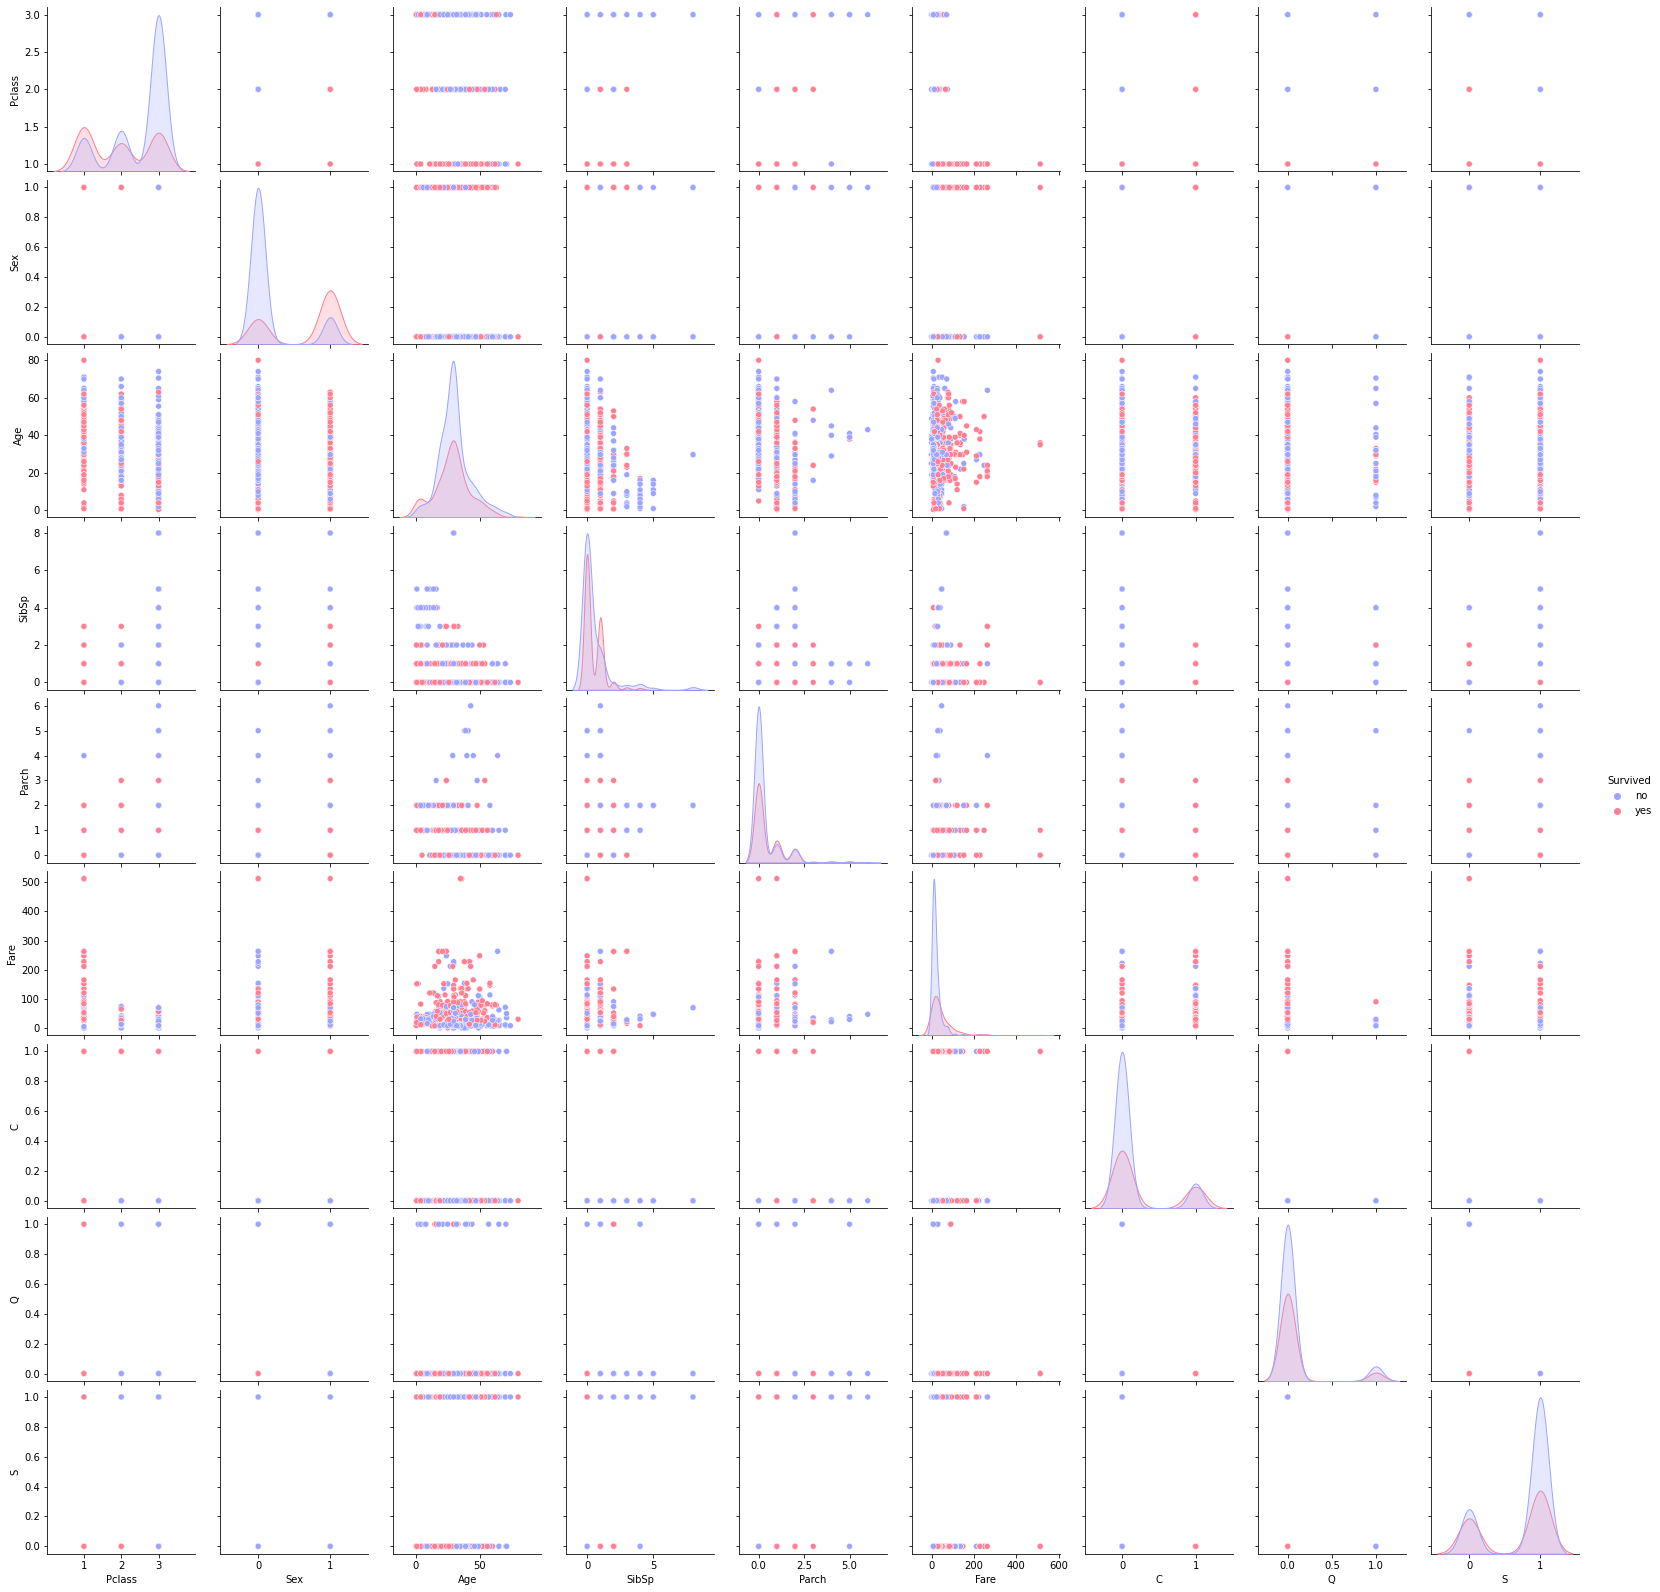

In [ ]:
sns.pairplot(df, hue="Survived", palette = {'no': '#9ca5ff', 'yes': '#ff8093'})

Jitter plot might be an appropriate alternative, yet not perfect either: as the data is quite noisy (and it is not always clear why one person survived and not there), it is hard to generalize the insights using only the Jitter plots.

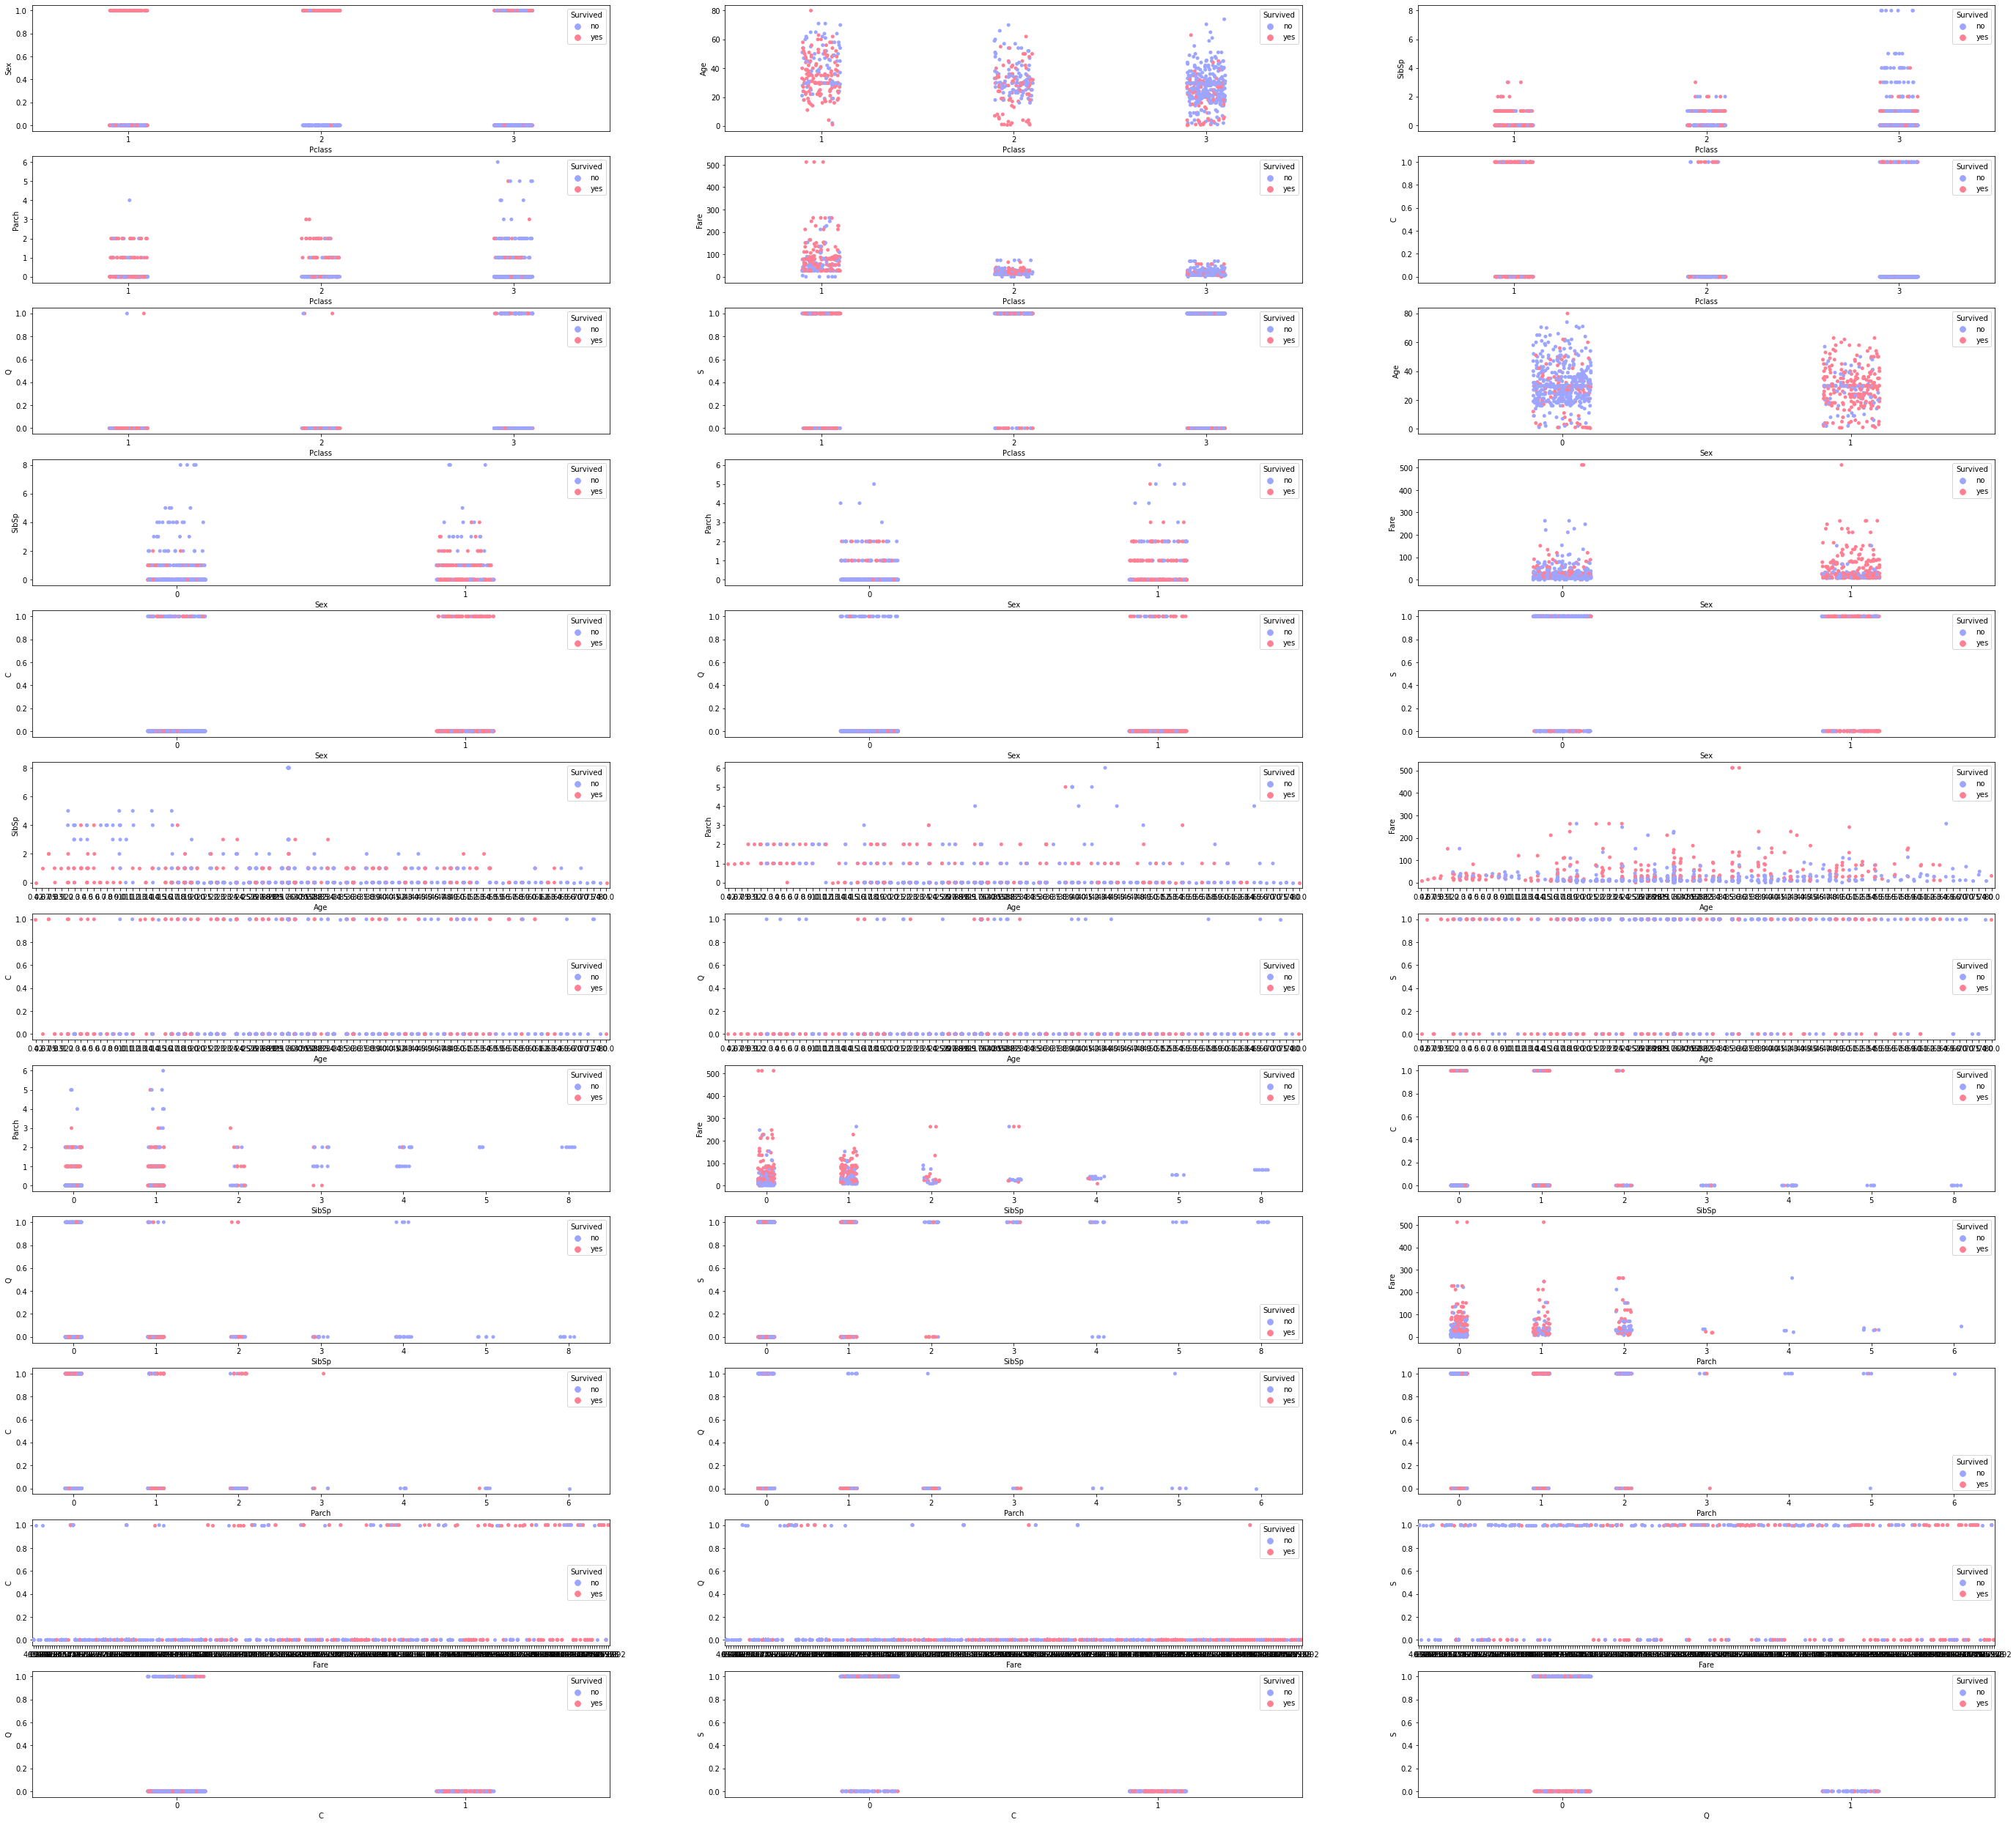

In [ ]:
import math

class_index = 0
attributes = list(df.columns[:class_index]) + list(df.columns[class_index + 1:])
combinations_count = int(len(attributes) * (len(attributes) - 1) / 2)

x_ax_count = math.ceil(combinations_count / 3)
y_ax_count = 3

fig, axs = plt.subplots(x_ax_count,y_ax_count)
fig.set_size_inches(x_ax_count * 4,y_ax_count * 15 )

ax_index = 0

for i in range(len(attributes)):
  for j in range(i + 1, len(attributes)):
      sns.stripplot(x=attributes[i],y=attributes[j],hue='Survived',data=df, ax = axs[int(ax_index / y_ax_count)][ax_index % y_ax_count], palette = {'no': '#9ca5ff', 'yes': '#ff8093'})
      ax_index +=1

# Part 4: Analyzing the data using ICC plots

In the following code, I'll present how ICC will plot the data.

In [ ]:
#@title Press here to load ICC code

import numpy as np
import graphviz
import matplotlib.colors as mc
import re
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from PIL import Image

PRESENT_ALL = 'all'
PRESENT_VISITED = 'visited'
PRESENT_MISCLASSIFIED = 'misclassified'

##################
## Graphvitz utils

replace_words = ['<thead>', '<tbody>', '</thead>', '</tbody>', '\n', '\rn', '<table border="1" class="dataframe">',
                 '</table>']
pattern = '|'.join(replace_words)

def dataframe_to_graphviz_table(df):
    '''
    Translates a html table to graphviz format
    references:
    https://renenyffenegger.ch/notes/tools/Graphviz/attributes/label/HTML-like/index
    https://graphviz.org/Gallery/gradient/table.html
    '''
    html_table = df.to_html()
    return re.sub(pattern, '', html_table).replace('th', 'td').replace('<td>', '<td border="1" bgcolor = "white">')

def to_graphviz_format(node_header, cm):
    cm_table = dataframe_to_graphviz_table(cm)
    return '<<table border = "0">' \
           '<tr><td border = "0" colspan="3"><b>%s</b></td></tr>' \
            '%s' \
           '</table>>' % (node_header, cm_table)

####################
def create_legend (expected_label, predicted_label, expected_label_color, predicted_label_color,
                   present_legends_header):
    elc = color_to_hex(expected_label_color)
    plc = color_to_hex(predicted_label_color)
    if present_legends_header:
        return f'<<table border = "0">' \
               f'<tr><td border = "1" bgcolor= "{elc}"> expected label </td> \
                    <td border = "1" bgcolor= "{plc}"> predicted label </td></tr>' \
               f'<tr><td border = "1" bgcolor= "{elc}"> {expected_label} </td> \
                    <td border = "1" bgcolor= "{plc}"> {predicted_label} </td></tr>' \
               f'</table>>'
    else:
        return f'<<table border = "0">' \
               f'<tr><td border = "1" bgcolor= "{elc}"> {expected_label} </td> \
                    <td border = "1" bgcolor= "{plc}"> {predicted_label} </td></tr>' \
               f'</table>>'

def create_cm_for_node(tp, fp, tn, fn, true_label, false_label):
    if tp == 0 and fp == 0 and tn == 0 and fn == 0:
        return None
    else:
        return pd.DataFrame({false_label: [tn, fn], true_label: [fp, tp]}, index = [false_label,true_label])

def get_nodes_visits_count_list(n_nodes, node_indicator, samples_ids):
    visits_count = [0] * n_nodes
    for sample_id in samples_ids:
        # obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
        node_indexes = node_indicator.indices[
                     node_indicator.indptr[sample_id]: node_indicator.indptr[sample_id + 1]
                     ]
        for node_index in node_indexes:
            visits_count[node_index] += 1
    return visits_count

def color_to_hex(color):
    try:
        color = mc.cnames[color]
    except:
        pass
    return color

def merge_color(first_color, first_color_quantity, second_color, second_color_quantity):
    if first_color_quantity == 0 and second_color_quantity == 0:
        return 'white'
    else:
        fc = color_to_hex(first_color)
        sc = color_to_hex(second_color)
        fc_rgb = tuple(int(fc.lstrip('#')[i:i+2], 16) for i in (0, 2, 4))
        sc_rgb = tuple(int(sc.lstrip('#')[i:i+2], 16) for i in (0, 2, 4))
        total = first_color_quantity + second_color_quantity
        adjusted_r = round((first_color_quantity * fc_rgb[0] + second_color_quantity * sc_rgb[0]) / total)
        adjusted_g = round((first_color_quantity * fc_rgb[1] + second_color_quantity * sc_rgb[1]) / total)
        adjusted_b = round((first_color_quantity * fc_rgb[2] + second_color_quantity * sc_rgb[2]) / total)
        return '#%02x%02x%02x' % (adjusted_r, adjusted_g, adjusted_b)

def plot_misclassification_in_tree(clf, X, y, expected_label, predicted_label,
                                   expected_label_color, predicted_label_color,
                                   present_legends_header = True,
                                   show_cm = True, present = PRESENT_ALL,
                                   highlight_false_negative = True,
                                   present_misclassification = True,
                                   im_size = 1000):
    y = np.array(y)  # Will be easier if y is guaranteed to be of type np array
    v = graphviz.Digraph()

    v.node(str(-1), create_legend(expected_label, predicted_label, expected_label_color, predicted_label_color, present_legends_header),
           {'shape': 'component', 'style': 'filled', 'fillcolor': 'white'})

    n_nodes = clf.tree_.node_count
    children_left = clf.tree_.children_left
    children_right = clf.tree_.children_right
    feature = clf.tree_.feature
    threshold = clf.tree_.threshold

    classification = clf.predict(X)
    node_indicator = clf.decision_path(X)

    # Step 1: check how the true data traverse along the classifier
    expected_label_labeled_samples_ids = [i for i in range(len(X)) if y[i] == expected_label]
    predicted_label_labeled_samples_ids = [i for i in range(len(X)) if y[i] == predicted_label]

    expected_label_labeled_visit_count = get_nodes_visits_count_list(n_nodes, node_indicator, expected_label_labeled_samples_ids)
    predicted_label_labeled_visits_count = get_nodes_visits_count_list(n_nodes, node_indicator, predicted_label_labeled_samples_ids)

    # Step 2: inspect how the classifier would classify the samples - and create a confusion marix for it.
    true_positive_samples_ids = [i for i in range(len(X)) if
                                 y[i] == expected_label and classification[i] == expected_label]
    false_positive_samples_ids = [i for i in range(len(X)) if
                                  y[i] == predicted_label and classification[i] == expected_label]
    true_negative_samples_ids = [i for i in range(len(X)) if
                                 y[i] == predicted_label and classification[i] == predicted_label]
    false_negative_samples_ids = [i for i in range(len(X)) if
                                  y[i] == expected_label and classification[i] == predicted_label]

    tp_visits_count = get_nodes_visits_count_list(n_nodes, node_indicator, true_positive_samples_ids)
    fp_visits_count = get_nodes_visits_count_list(n_nodes, node_indicator, false_positive_samples_ids)
    tn_visits_count = get_nodes_visits_count_list(n_nodes, node_indicator, true_negative_samples_ids)
    fn_visits_count = get_nodes_visits_count_list(n_nodes, node_indicator, false_negative_samples_ids)

    if PRESENT_ALL == present:
        nodes_ids_to_plot = range(n_nodes)
    elif PRESENT_VISITED == present:
        total_visits_count = [sum(x) for x in zip(tp_visits_count, fp_visits_count, tn_visits_count, fn_visits_count)]
        nodes_ids_to_plot = [i for i in range(len(total_visits_count)) if total_visits_count[i] > 0]
    elif PRESENT_MISCLASSIFIED == present:
        nodes_ids_to_plot = [i for i in range(len(fn_visits_count)) if fn_visits_count[i] > 0]
    else:
        raise Exception('Uknown present value: %s' % present)

    for i in nodes_ids_to_plot:
        node_id = str(i)

        if children_left[i] == children_right[i]: # this is a leaf
            label = str(clf.classes_[np.argmax(clf.tree_.value[i])])
            if show_cm:
                cm = create_cm_for_node(tp_visits_count[i], fp_visits_count[i], tn_visits_count[i], fn_visits_count[i], expected_label, predicted_label)
                if cm is None:
                    node_content = label
                else:
                    node_content = to_graphviz_format(label, cm)
            else:
                node_content = label
            peripheries = '2' if highlight_false_negative and fn_visits_count[i] > 0 else '1'
            fill_color = merge_color(expected_label_color, expected_label_labeled_visit_count[i], predicted_label_color, predicted_label_labeled_visits_count[i])
            v.node(node_id, node_content, {'shape': 'rect', 'style': 'filled', 'fillcolor': fill_color, 'peripheries': peripheries})

        else: # this is a split node
            node_feature = X.columns[feature[i]]
            node_tresshold = threshold[i]

            label = str(node_feature)
            if show_cm:
                cm = create_cm_for_node(tp_visits_count[i], fp_visits_count[i], tn_visits_count[i], fn_visits_count[i], expected_label, predicted_label)
                if cm is None:
                    node_content = label
                else:
                    node_content = to_graphviz_format(label, cm)
            else:
                node_content = label

            fill_color = merge_color(expected_label_color, expected_label_labeled_visit_count[i], predicted_label_color, predicted_label_labeled_visits_count[i])
            peripheries = '2' if highlight_false_negative and fn_visits_count[i] > 0 else '1'
            v.node(node_id, node_content, {'shape': 'rect', 'style': 'filled', 'fillcolor': fill_color, 'peripheries': peripheries})

            if children_left[i] in nodes_ids_to_plot:
                v.edge(node_id, str(children_left[i]), node_feature + "<=" + str(round(node_tresshold, 5)))
            if children_right[i] in nodes_ids_to_plot:
                v.edge(node_id, str(children_right[i]), node_feature + ">" + str(round(node_tresshold, 5)))
    if present_misclassification:
        v.node(str(n_nodes), f'Total misclassification: {len(false_negative_samples_ids)}/{len(X)}',  {'shape': 'underline'}) # TODO replace with existing conut
    
    # v.render(directory='doctest-output', view=True, format='jpeg')
    output_path = v.render(format = 'jpg')
    im = Image.open(output_path) 
      
    # resize the image for better presentation 
    width, height = int(im.width / im.height * im_size), im_size
    im_resized = im.resize((width, height))
    return im_resized

def visualize(X, y, label1, label2, label1_color, label2_color, show_cm = True, max_depth = None, im_size = 1000):
    clf = DecisionTreeClassifier(random_state=42) if max_depth is None else  DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    clf.fit(X, y)
    return plot_misclassification_in_tree(clf = clf, X = X, y = y, expected_label = label1, predicted_label = label2,
                                   expected_label_color = label1_color, predicted_label_color = label2_color,
                                   present_legends_header = False,
                                   show_cm = show_cm, present = PRESENT_ALL,
                                   highlight_false_negative = False,
                                   present_misclassification = False,
                                   im_size = im_size)

In [ ]:
X = df.drop(['Survived'],axis=1)
y = df['Survived']

visualize(X, y, 'yes', 'no', '#ff8093', '#9ca5ff', show_cm = True, max_depth = 4, im_size = 2000)

Output hidden; open in https://colab.research.google.com to view.

Here, we can observe that the data is quite messy with multiple subplanes containing significant amounts of samples from both classes.

When plotting the tree without any constraints (max_depth = None), we can see that (1) the tree becomes quite high, indicating the presence of samples with similar characteristics that are almost identical except for their class, and (2) there are leaves with samples of both classes, meaning there are instances with the exact same attributes but from different class. These factors can explain why a classifier may make incorrect predictions. In addition, this can be easily missed when using Scatter or Jitter plots.

In [ ]:
X = df.drop(['Survived'],axis=1)
y = df['Survived']

visualize(X, y, 'yes', 'no', '#ff8093', '#9ca5ff', show_cm = True, max_depth = None, im_size = 3000)

Output hidden; open in https://colab.research.google.com to view.

An example of the leaves discussed above:

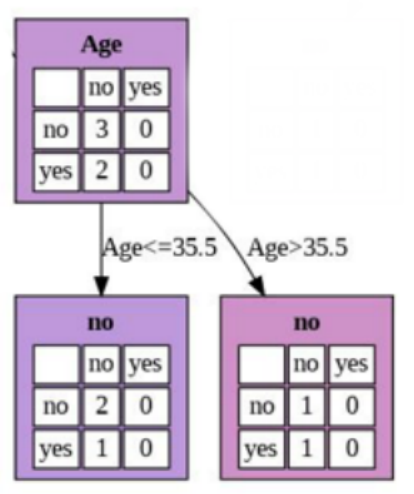